In [85]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectFromModel

In [86]:
# Đọc dữ liệu từ các file CSV
message_gold_label = pd.read_csv('data/message_gold_label.csv')
potential = pd.read_csv('data/potential.csv')
campaign = pd.read_csv('data/campaigns.csv')

# Kết hợp các DataFrame thành một DataFrame duy nhất
data = pd.concat([message_gold_label, potential], ignore_index=True)
data = data[data['message_type'] == 'bulk']  # Chỉ giữ lại các dòng có message_type là 'bulk'

# Loại bỏ các cột không cần thiết
columns_to_drop = ['is_unsubscribed', 'unsubscribed_at', 'complained_at','is_complained', 'is_blocked', 
                   'blocked_at', 'purchased_at', 'date', 'campaign_message','opened_first_time_at',
                   'clicked_first_time_at','is_opened','is_clicked','client_id','message_id']
data = data.drop(columns=columns_to_drop)

columns_to_drop_campaign = ['is_test','position','hour_limit','warmup_mode','ab_test','started_at','finished_at','total_count']
campaign = campaign.drop(columns=columns_to_drop_campaign)

data

,campaign_id,message_type,channel,sent_at,opened_last_time_at,clicked_last_time_at,is_purchased,duration
4000,136,bulk,email,2021-05-19 07:50:47,2021-05-20 02:41:19,2021-05-20 02:41:19,True,22.0
4001,136,bulk,email,2021-05-19 07:07:20,2021-05-19 20:05:03,2021-05-19 20:05:03,True,31451.0
4002,136,bulk,email,2021-05-19 07:01:43,2021-05-20 11:45:38,2021-05-20 11:45:38,True,37.0
4003,136,bulk,email,2021-05-19 07:43:20,2021-05-20 11:38:03,2021-05-20 11:38:03,True,12.0
4004,136,bulk,email,2021-05-19 07:51:26,2021-05-19 16:06:28,2021-05-19 16:06:28,True,10.0
...,...,...,...,...,...,...,...,...
228880,361,bulk,email,2021-06-11 08:10:09,2021-06-11 08:17:33,2021-06-11 08:17:33,False,44.0
228881,361,bulk,email,2021-06-11 08:04:45,2021-06-11 09:30:11,2021-06-11 09:30:11,False,1639.0
228882,361,bulk,email,2021-06-11 08:05:53,2021-06-11 08:27:04,2021-06-11 08:27:04,False,7.0
228883,361,bulk,email,2021-06-11 08:08:00,2021-06-11 12:42:17,2021-06-11 12:42:17,False,9.0


In [87]:
# Kết hợp dữ liệu từ hai bảng data và campaign
merged_data = pd.merge(data, campaign, 
                       left_on=['campaign_id','message_type'], 
                       right_on=['id', 'campaign_type'])
merged_data = merged_data.drop(columns=['id','campaign_type','channel_y','campaign_id','message_type'])

merged_data.head()

,channel_x,sent_at,opened_last_time_at,clicked_last_time_at,is_purchased,duration,topic,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout
0,email,2021-05-19 07:50:47,2021-05-20 02:41:19,2021-05-20 02:41:19,True,22.0,sale out,133.0,False,False,True,False,False,False
1,email,2021-05-19 07:07:20,2021-05-19 20:05:03,2021-05-19 20:05:03,True,31451.0,sale out,133.0,False,False,True,False,False,False
2,email,2021-05-19 07:01:43,2021-05-20 11:45:38,2021-05-20 11:45:38,True,37.0,sale out,133.0,False,False,True,False,False,False
3,email,2021-05-19 07:43:20,2021-05-20 11:38:03,2021-05-20 11:38:03,True,12.0,sale out,133.0,False,False,True,False,False,False
4,email,2021-05-19 07:51:26,2021-05-19 16:06:28,2021-05-19 16:06:28,True,10.0,sale out,133.0,False,False,True,False,False,False


In [88]:
# Hàm để trích xuất các đặc trưng thời gian từ các cột datetime
def extract_datetime_features(X, datetime_columns):
    for col in datetime_columns:
        if col in X.columns:
            X[col + '_weekday'] = pd.to_datetime(X[col]).dt.weekday  # Trích xuất ngày trong tuần
            X[col + '_hour'] = pd.to_datetime(X[col]).dt.hour  # Trích xuất giờ trong ngày
            X[col + '_month'] = pd.to_datetime(X[col]).dt.month  # Trích xuất tháng
            X = X.drop(columns=[col])  # Loại bỏ cột datetime gốc
    return X
merged_data_date_time_feature = extract_datetime_features(merged_data, ['sent_at','opened_last_time_at','clicked_last_time_at'])

In [89]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Hàm để mã hóa các cột phân loại bằng LabelEncoder
def drop_and_encode(df, encode_columns):
    le = LabelEncoder()
    for col in encode_columns:
        if col in df.columns:
            df[col] = df[col].fillna('missing').astype(str)  # Thay thế NaN bằng 'missing' để tránh lỗi
            df[col + '_encoded'] = le.fit_transform(df[col])  # Mã hóa cột thành số
            df = df.drop(columns=[col])  # Loại bỏ cột gốc sau khi mã hóa
    return df

# Hàm xử lý các cột boolean, chuyển đổi thành 0 và 1
def process_bool_columns(df, bool_columns):
    for col in bool_columns:
        if col in df.columns:
            df[col] = df[col].astype(int)  # Chuyển đổi boolean thành 0 và 1
    return df

# Hàm chuyển đổi các cột thành dạng số
def convert_to_numeric(df, numerical_columns):
    for col in numerical_columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')  # Chuyển thành số và xử lý lỗi
    return df

# Ví dụ sử dụng các hàm trên để xử lý dữ liệu
encode_columns = ['topic', 'channel_x']
merged_data_date_time_feature = drop_and_encode(merged_data_date_time_feature, encode_columns)

bool_columns = [ 'subject_with_personalization', 'subject_with_deadline',
                 'subject_with_emoji', 'subject_with_bonuses', 
                 'subject_with_discount', 'subject_with_saleout', 'is_purchased']
merged_data_date_time_feature = process_bool_columns(merged_data_date_time_feature, bool_columns)

numerical_columns = ['channel_x', 'duration', 'topic', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour',
       'sent_at_month', 'opened_last_time_at_weekday',
       'opened_last_time_at_hour', 'opened_last_time_at_month',
       'clicked_last_time_at_weekday', 'clicked_last_time_at_hour',
       'clicked_last_time_at_month']
merged_data_date_time_feature = convert_to_numeric(merged_data_date_time_feature, numerical_columns)

# Kiểm tra dữ liệu sau khi xử lý
merged_data_date_time_feature

,is_purchased,duration,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,sent_at_weekday,sent_at_hour,sent_at_month,opened_last_time_at_weekday,opened_last_time_at_hour,opened_last_time_at_month,clicked_last_time_at_weekday,clicked_last_time_at_hour,clicked_last_time_at_month,topic_encoded,channel_x_encoded
0,1,22.0,133.0,0,0,1,0,0,0,2,7,5,3,2,5,3,2,5,2,0
1,1,31451.0,133.0,0,0,1,0,0,0,2,7,5,2,20,5,2,20,5,2,0
2,1,37.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
3,1,12.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
4,1,10.0,133.0,0,0,1,0,0,0,2,7,5,2,16,5,2,16,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86506,0,44.0,87.0,0,1,1,0,0,0,4,8,6,4,8,6,4,8,6,2,0
86507,0,1639.0,87.0,0,1,1,0,0,0,4,8,6,4,9,6,4,9,6,2,0
86508,0,7.0,87.0,0,1,1,0,0,0,4,8,6,4,8,6,4,8,6,2,0
86509,0,9.0,87.0,0,1,1,0,0,0,4,8,6,4,12,6,4,12,6,2,0


In [90]:
# Xóa các dòng bị trùng lặp
cleaned_data = merged_data_date_time_feature.drop_duplicates()
cleaned_data

,is_purchased,duration,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,sent_at_weekday,sent_at_hour,sent_at_month,opened_last_time_at_weekday,opened_last_time_at_hour,opened_last_time_at_month,clicked_last_time_at_weekday,clicked_last_time_at_hour,clicked_last_time_at_month,topic_encoded,channel_x_encoded
0,1,22.0,133.0,0,0,1,0,0,0,2,7,5,3,2,5,3,2,5,2,0
1,1,31451.0,133.0,0,0,1,0,0,0,2,7,5,2,20,5,2,20,5,2,0
2,1,37.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
3,1,12.0,133.0,0,0,1,0,0,0,2,7,5,3,11,5,3,11,5,2,0
4,1,10.0,133.0,0,0,1,0,0,0,2,7,5,2,16,5,2,16,5,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86501,0,164.0,87.0,0,1,1,0,0,0,4,8,6,4,9,6,4,9,6,2,0
86502,0,31.0,87.0,0,1,1,0,0,0,4,8,6,5,0,6,5,0,6,2,0
86503,0,64.0,87.0,0,1,1,0,0,0,4,8,6,3,5,6,2,6,6,2,0
86507,0,1639.0,87.0,0,1,1,0,0,0,4,8,6,4,9,6,4,9,6,2,0


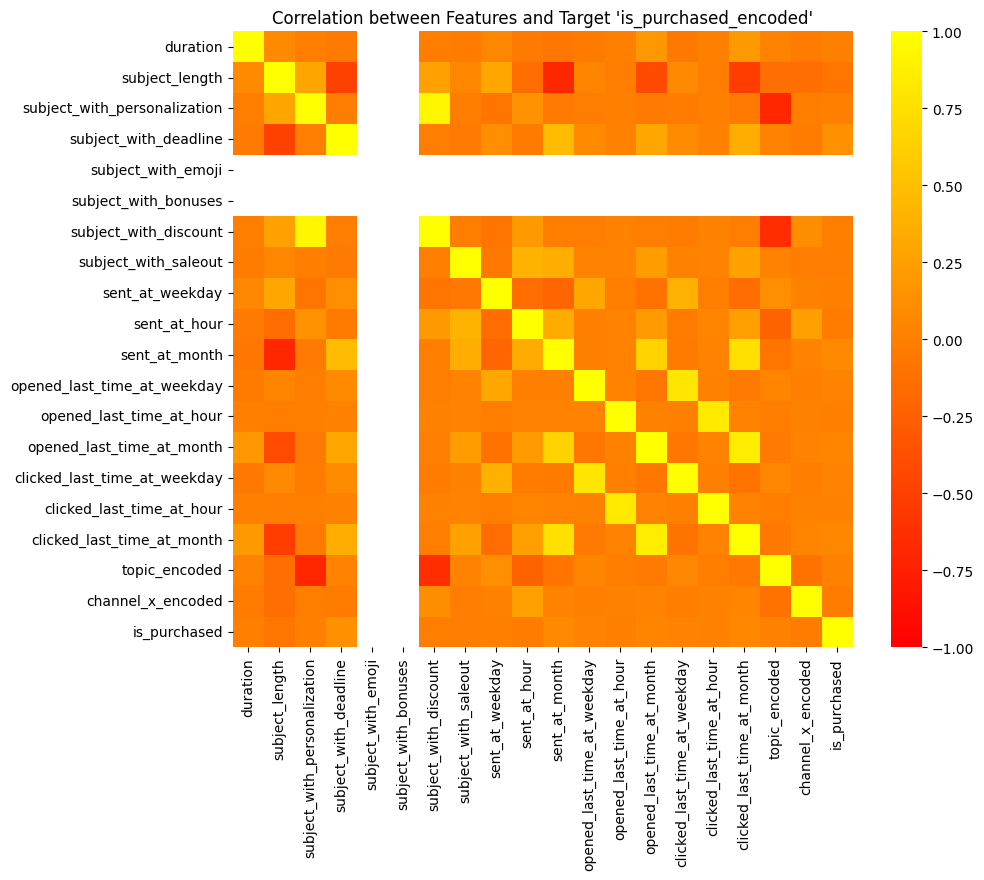

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Các đặc trưng số cần sử dụng trong phân tích tương quan
numerical_features  =['duration', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour',
       'sent_at_month', 'opened_last_time_at_weekday',
       'opened_last_time_at_hour', 'opened_last_time_at_month',
       'clicked_last_time_at_weekday', 'clicked_last_time_at_hour',
       'clicked_last_time_at_month', 'topic_encoded', 'channel_x_encoded']

# Tính toán ma trận tương quan giữa các đặc trưng và mục tiêu 'is_purchased'
correlation_matrix = cleaned_data[numerical_features + ['is_purchased']].corr()

# Vẽ biểu đồ nhiệt để thể hiện tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, vmin=-1, vmax=1, cmap='autumn')
plt.title("Correlation between Features and Target 'is_purchased_encoded'")
plt.show()

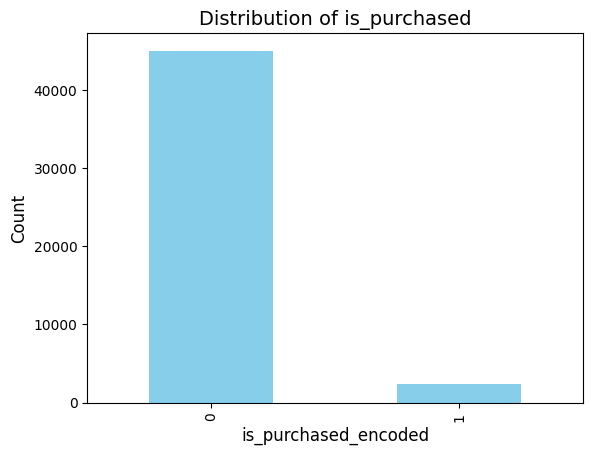

In [92]:
# Vẽ biểu đồ tần suất phân phối của mục tiêu 'is_purchased'
purchase_counts = cleaned_data['is_purchased'].value_counts()
purchase_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of is_purchased', fontsize=14)
plt.xlabel('is_purchased_encoded', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Dữ liệu bị mất cân bằng
- Undersampling giúp giảm kích thước dữ liệu và tiết kiệm tài nguyên tính toán, rất hữu ích khi tài nguyên bị hạn chế.
- Oversampling có thể làm tăng kích thước dữ liệu, điều này gây khó khăn khi tài nguyên tính toán bị giới hạn

In [93]:
# Tạo X và y cho mô hình học máy
X = cleaned_data.drop(columns=['is_purchased'])  # Dữ liệu đặc trưng
y = cleaned_data['is_purchased']  # Biến mục tiêu

# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Sử dụng RandomUnderSampler để xử lý mất cân bằng lớp
undersampler = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = undersampler.fit_resample(X_train, y_train)

C:\Users\miynzi\AppData\Local\Temp\ipykernel_20544\3279478571.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette="Set2")


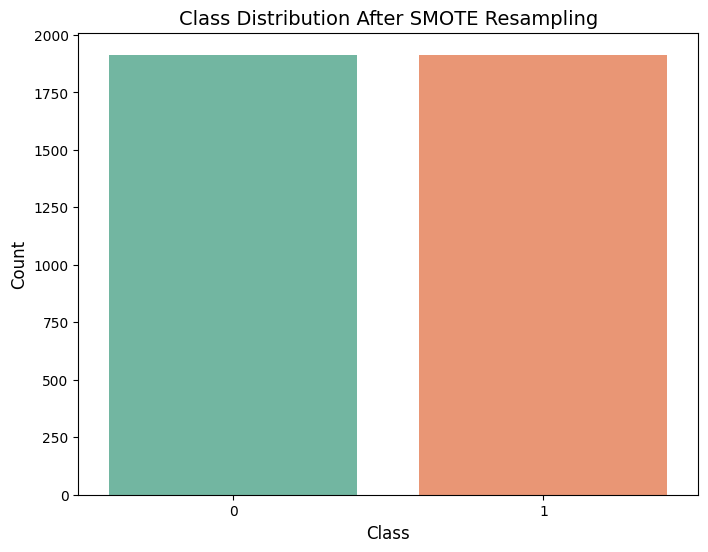

In [94]:
# Vẽ phân phối lại của lớp sau khi áp dụng undersampling
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res, palette="Set2")
plt.title('Class Distribution After SMOTE Resampling', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# MODEL

In [95]:
# Định nghĩa pipeline Logistic Regression với Scaling và Feature Selection
logistic_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42))),
    ('classifier', LogisticRegression(random_state=42))
])

# Tìm tham số tối ưu bằng GridSearchCV
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1'],
    'classifier__max_iter': [100, 200, 500]
}
grid_search = GridSearchCV(logistic_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_res, y_train_res)

# Đánh giá mô hình trên tập kiểm tra
y_pred = grid_search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# Sử dụng Cross-Validation để đánh giá toàn diện
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(grid_search.best_estimator_, X_train_res, y_train_res, cv=kf, scoring='accuracy')

# In kết quả
print("Logistic Regression Best Parameters:", grid_search.best_params_)
print("Logistic Regression Test Accuracy:", accuracy)
print("Logistic Regression Test MSE:", mse)
print("Cross-Validation Accuracy Mean:", cv_scores.mean())
print("Cross-Validation Accuracy Std:", cv_scores.std())

# In các đặc trưng được chọn
selected_features = X_train_res.columns[grid_search.best_estimator_.named_steps['feature_selection'].get_support()]
print("Selected Features:", list(selected_features))

Logistic Regression Best Parameters: {'classifier__C': 0.1, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Logistic Regression Test Accuracy: 0.8217936558119928
Logistic Regression Test MSE: 0.17820634418800715
Cross-Validation Accuracy Mean: 0.5679192477687331
Cross-Validation Accuracy Std: 0.007056572374345229
Selected Features: ['duration', 'subject_length', 'subject_with_personalization', 'subject_with_deadline', 'subject_with_saleout', 'sent_at_weekday', 'sent_at_hour', 'sent_at_month', 'opened_last_time_at_weekday', 'opened_last_time_at_hour', 'opened_last_time_at_month', 'clicked_last_time_at_weekday', 'clicked_last_time_at_hour', 'clicked_last_time_at_month', 'topic_encoded', 'channel_x_encoded']


### Sau khi dùng phương pháp 

**Tổng quan:**
- Độ chính xác trên tập kiểm tra (Test Accuracy): 82.18% là một kết quả khá tốt trong bài toán phân loại. Điều này cho thấy mô hình đã hoạt động ổn định, nhưng vẫn còn dư địa để cải thiện.
- MSE (Mean Squared Error): 0.1782 cho thấy mức độ sai số trung bình của mô hình không quá lớn, nhưng vẫn tồn tại sai lệch trong dự đoán.
- Độ chính xác trung bình qua Cross-Validation: 56.79% với độ lệch chuẩn nhỏ (0.0071), cho thấy mô hình chưa tổng quát tốt trên tập huấn luyện khi sử dụng kỹ thuật Cross-Validation.

**Đánh giá mô hình:** 
1. Tính ổn định của Accuracy (độ chính xác)::
- Accuracy có thể dao động từ 75% đến 78% do:
- Undersampling: Phương pháp này làm giảm số lượng mẫu từ lớp chiếm ưu thế, dẫn đến các tập dữ liệu huấn luyện khác nhau mỗi khi chạy.
- Việc loại bỏ các mẫu khác nhau ở mỗi lần undersampling dẫn đến sự thay đổi trong dữ liệu huấn luyện, từ đó ảnh hưởng đến kết quả dự đoán của mô hình.
2. Tính biến động của MSE (Mean Squared Error):
- MSE dao động từ 0.1 đến 0.25 vì:
- Sai số dự đoán: MSE đo lường sự sai lệch giữa giá trị dự đoán và giá trị thực tế. Khi sử dụng undersampling, tập dữ liệu huấn luyện thay đổi, làm cho mô hình học các đặc trưng khác nhau, dẫn đến mức sai số khác nhau.
3. Đặc trưng được chọn (Selected Features):
- Các đặc trưng quan trọng được chọn lọc từ mô hình bao gồm:
- Các đặc trưng về nội dung email: duration, subject_length, subject_with_personalization, subject_with_deadline, subject_with_saleout.
- Thời gian gửi email: sent_at_weekday, sent_at_hour, sent_at_month.
- Lịch sử mở email: opened_last_time_at_weekday, opened_last_time_at_hour, opened_last_time_at_month.
- Lịch sử click email: clicked_last_time_at_weekday, clicked_last_time_at_hour, clicked_last_time_at_month.
- Chủ đề và kênh giao tiếp: topic_encoded, channel_x_encoded.